In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
%pwd

'/mnt/c/Users/mtr22/code/mre-pinn/notebooks'

In [2]:
import sys, os
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

/home/mtr22/anaconda3/envs/MRE-PINN2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using backend: pytorch

Loading /mnt/c/Users/mtr22/code/mre-pinn/notebooks/../mre_pinn/__init__.py


In [3]:
# load the MATLAB file
data_root = '../data/BIOQIC'
mat_base = 'four_target_phantom.mat'

mat_file = data_root + '/' + mat_base
data, rev_axes = mre_pinn.data.load_mat_data(mat_file, verbose=True)

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128


In [182]:
# convert to xarray and add metadata
u_array = data['u_ft'].T
u_dims = ['frequency', 'component', 'z', 'x', 'y']
u_coords = {
    'frequency': 50 + np.arange(u_array.shape[0]) * 10, # Hz
    'x': np.arange(u_array.shape[3]) * 1, # mm
    'y': np.arange(u_array.shape[4]) * 1, # mm
    'z': np.arange(u_array.shape[2]) * 1, # mm
    'component': ['y', 'x', 'z'],
}
u_array = xr.DataArray(u_array, dims=u_dims, coords=u_coords)
u_array = u_array.transpose('frequency', 'x', 'y', 'z', 'component')
u_array = u_array.sel(frequency=50, z=0, component=['x', 'y'])
u_array

<xarray.DataArray (x: 80, y: 100, component: 2)>
array([[[ 4.41610136e-12+4.15293497e-13j,
          1.80392877e-03-2.21015603e-03j],
        [ 2.54974440e-12+1.05876021e-12j,
          1.89734370e-03-2.18494845e-03j],
        [ 0.00000000e+00+0.00000000e+00j,
          1.95992162e-03-2.15976800e-03j],
        ...,
        [ 0.00000000e+00+0.00000000e+00j,
         -1.49606247e-03+8.40557373e-04j],
        [-2.43980266e-12+2.99410724e-14j,
         -1.50236176e-03+8.61343421e-04j],
        [ 0.00000000e+00+0.00000000e+00j,
         -1.50187882e-03+8.89141659e-04j]],

       [[-1.04787094e-04-1.43479483e-05j,
          1.78532489e-03-2.20576001e-03j],
        [-6.69046137e-05-2.64826788e-05j,
          1.87508117e-03-2.18151355e-03j],
        [-3.69753952e-05-3.96238656e-05j,
          1.93444137e-03-2.15399541e-03j],
...
        [ 3.21308950e-04-1.58614413e-03j,
         -1.47214421e-03+3.39784381e-04j],
        [ 2.23235032e-04-1.71146535e-03j,
         -1.21303117e-03+3.22017078e-04j],
        [ 1.53694403e-04-1.84176483e-03j,
         -9.50755081e-04+2.81915877e-04j]],

       [[-2.64239471e-04-1.47929502e-03j,
          7.73650603e-04-9.50628846e-04j],
        [-1.87285939e-04-1.33198412e-03j,
          9.19854132e-04-1.00448328e-03j],
        [-7.52842778e-05-1.16772039e-03j,
          1.08602628e-03-1.04367315e-03j],
        ...,
        [ 4.00781994e-04-1.51666910e-03j,
         -1.57575780e-03+4.54481340e-04j],
        [ 2.91630176e-04-1.68451693e-03j,
         -1.30413755e-03+4.49660820e-04j],
        [ 2.19152692e-04-1.84301455e-03j,
         -1.03910716e-03+4.08667710e-04j]]])
Coordinates:
    frequency  int64 50
  * x          (x) int64 0 1 2 3 4 5 6 7 8 9 ... 70 71 72 73 74 75 76 77 78 79
  * y          (y) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
    z          int64 0
  * component  (component) <U1 'x' 'y'

In [204]:
%autoreload

# convert to point set boundary condition
u_bc = mre_pinn.data.NDArrayBC(u_array, batch_size=1024)
x = u_bc.points
u_true = u_bc.values.cpu().numpy()
x.shape, u_true.shape

((8000, 2), (8000, 2))

In [210]:
%autoreload

# set up PDE with geometry and boundary condition
residual = mre_pinn.pde.HelmholtzPDE(ndim=u_true.shape[1])
geometry = deepxde.geometry.Hypercube(x.min(axis=0), x.max(axis=0))
pde = deepxde.data.PDE(geometry, residual, u_bc, num_domain=1)
pde.train_x.shape

/home/mtr22/anaconda3/envs/MRE-PINN2/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+3=3. 
  warnings.warn("The balance properties of Sobol' points require "


(1025, 2)

In [211]:
%autoreload

# initialize neural network
net = mre_pinn.model.Parallel([
    mre_pinn.model.ComplexFFN(
        n_input=x.shape[1],
        n_layers=3,
        n_hidden=16,
        n_output=n_output,
        activ_fn=torch.sin,
        w0=1
    ) for n_output in [u_true.shape[1], 1] # u and mu
])

x = u_bc.points
u_true = u_bc.values.cpu().numpy()

# standardize inputs to [-1, 1]
x_loc = np.mean(x, axis=0)
x_scale = (np.max(x, axis=0) - np.min(x, axis=0)) / 2

# normalize outputs
u = np.concatenate([u_true.real, u_true.imag], axis=1)
u_loc = np.mean(u, axis=0)
u_scale = np.std(u, axis=0)

# initialize model weights
net[0].init_weights(input_loc=x_loc, input_scale=x_scale, output_scale=u_scale, output_loc=u_loc)
net[1].init_weights(input_loc=x_loc, input_scale=x_scale, output_scale=1, output_loc=10)

net

Parallel(
  (0): ComplexFFN(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=18, out_features=16, bias=True)
    (2): Linear(in_features=34, out_features=4, bias=True)
  )
  (1): ComplexFFN(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=18, out_features=16, bias=True)
    (2): Linear(in_features=34, out_features=2, bias=True)
  )
)

In [212]:
def msae_loss(y_true, y_pred):
    '''
    Mean squared absolute error.
    '''
    error = torch.abs(y_true - y_pred)
    return torch.mean(error**2)

model = deepxde.Model(pde, net)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss=msae_loss,
    loss_weights=[0, 1]
)

Compiling model...
'compile' took 0.000755 s



Training model...



<IPython.core.display.Javascript object>


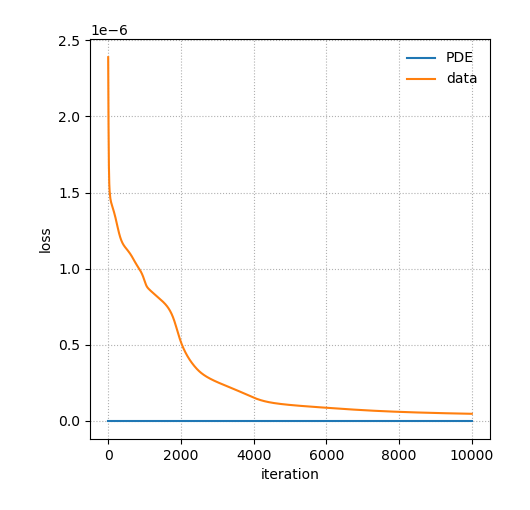


Best model at step 10000:
  train loss: 4.61e-08
  test loss: 4.61e-08
  test metric: []

'train' took 191.180930 s



In [213]:
deepxde.display.training_display = mre_pinn.visual.TrainingPlot()
try:
    model.train(10000, display_every=10)
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

In [ ]:
#torch.save(net.state_dict(), 'fem_box.model')

In [214]:
# model predictions
outputs = model.predict(u_bc.points)
u_pred = outputs[:,:-1].reshape(u_array.shape)
mu_pred = outputs[:,-1].reshape(u_array.shape[:-1])

u_pred.shape, mu_pred.shape

((80, 100, 2), (80, 100))

<IPython.core.display.Javascript object>


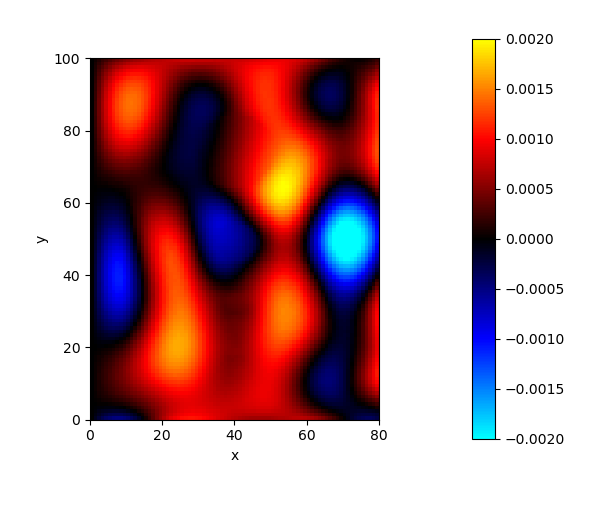

<IPython.core.display.Javascript object>


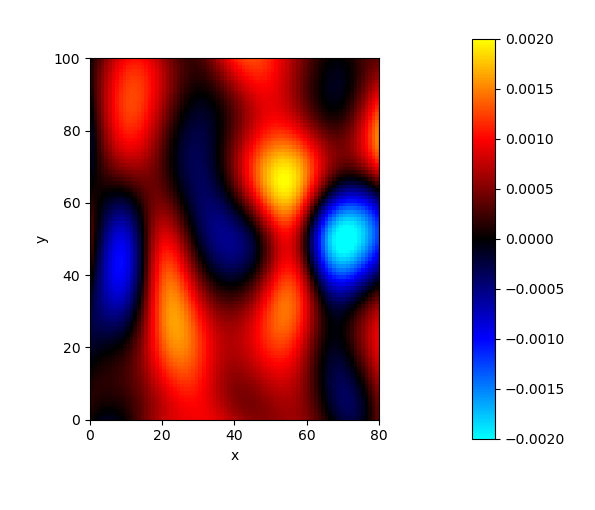

<IPython.core.display.Javascript object>


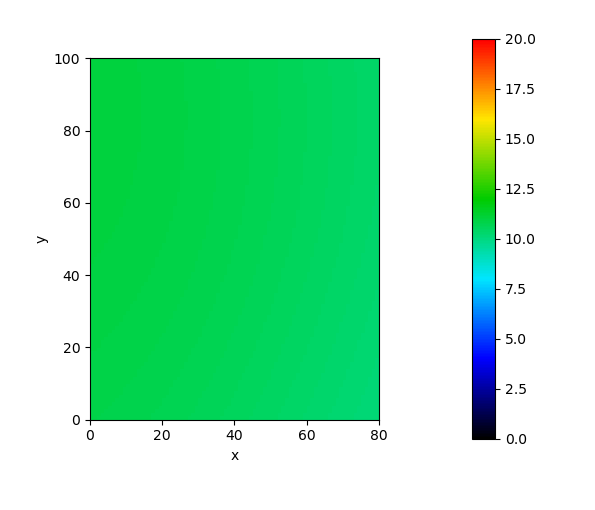

In [215]:
%autoreload

# display model predictions
w_map = mre_pinn.visual.wave_color_map()
e_map = mre_pinn.visual.elast_color_map()
w_max = 0.002
e_max = 20

mre_pinn.visual.NDArrayViewer(u_array.real[...,0], u_array.dims[:-1], cmap=w_map, vmin=-w_max, vmax=w_max)
mre_pinn.visual.NDArrayViewer(u_pred.real[...,0], u_array.dims[:-1], cmap=w_map, vmin=-w_max, vmax=w_max)
mre_pinn.visual.NDArrayViewer(mu_pred.real, u_array.dims[:-1], cmap=e_map, vmin=0, vmax=e_max)